# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



# Problem Statement

We have three datasets:
- portfolio that describes details about each offer
- profile that describes details about each customer
- transcript that register every event during the experiment: transaction, offer received, viewed, and completed

These three datasets together give us a picture of customers and their reactions to a particular offer, did they pursue the offer and made a purchase or ignored it?

**The higher level business question that we are going to ask:** 
- What kind of offer should we give to a customer, so the customer would make a purchase?

**Smaller business questions we would like answer:**
1. What is the age distribution of Starbucks customers?
2. What is the income distribution of Starbucks customers?
3. How many people joined Starbucks membership each year?
4. How many people abandoned each kind of offers? Which offer gets abandoned the most? Least?
5. What is the rate of completion for each offer? How do they compare within each offer type?
6. What is the general demographic of people who ignore offers, not viewing them?
7. What is the general demographic of people who complete offers by accident?
8. What is the distribution of total rewards and total amount spend by customers?
9. What is the most popular offer?
10. What is the least popular offer?
  
In order to create a ML model that would help the business to predict whether or not to send any customer an offer, we are going to create a new data frame that contains customer demographic information and some features about customer's previous experience with the app/purchases and offer information. Once the model is trained on the data we have collected during the experiment, the business would be able to feed the model customer information, pair them with information on each offer to figure out, which offers would influence a customer into making a purchase.

Since we are trying to predict a True/False value on whether or not the customer would make a purchase, this is a classification problem, therefore, we need to use classification models in ML section.

We are going to fit multiple classification models, like Logistic Regression, K Nearest Neighbors Classifier, XGBoost Classifier, and others to identify one that performs the best. Then we would use GridSearchCV to perform a hyperparameter tuning and test/evaluate the model with best parameters.

Our goal is to achieve the highest accuracy without overfitting the model.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in c:\users\maria\anaconda3\lib\site-packages (0.8.0)
Note: you may need to restart the kernel to use updated packages.


In [91]:
import plotly.express as px
import datetime
from collections import defaultdict
from tqdm import tqdm
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE


### Functions Setup

The functions below are helpers to map string id to numeric ids using pre-defined dictionaries.

In [4]:
def offer_mapper(value, key1, key2):
    '''
    Function takes in a dictionary, which
    contains alpha-numeric id as key and two possible spellings of the key and returns the value 
    '''
    if key1 in value:
        return value[key1]
    if key2 in value:
        return value[key2]
    
def reward_mapper(value, key1):
    '''
    Function takes in a dictionary, which
    contains alpha-numeric id as key and key and returns the value. 
    If the key is missing, it returns zero
    '''
    if key1 in value:
        return value[key1]
    else:
        return 0

In [5]:
def id_mapper(df, col_name):
    '''
    Function takes in a daraframe, which
    contains alpha-numeric ids and the column name of the column that contains
    the ids, and creates a numeric id for each unique alpha-numeric id
    '''
    
    id_dict = {}
    id_counter = 1
    for idx in range(df.shape[0]):
        if ~(df[col_name].iloc[idx] in id_dict):
            id_dict[df[col_name].iloc[idx]] = id_counter
            id_counter += 1
    return id_dict

In [92]:
def display_results(y_pred, y_test):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels = labels)
    accuracy = (y_test == y_pred).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
 

### Review available dataframes

Display first few rows of each available dataframe to get a sense of data and what formats it is given in

In [6]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### Data Cleaning

First, we are going to rename ID columns to bring these columns to a more standard form and to avoid confusion, which id we are referring to during analysis. 

Even though string id are okay, it is more workable to store id in form of numbers. Using function defined above, we are going to create dictionaries that would map string ids to numerical ids.

In [9]:
#rename columns to bring the same data to the same format
portfolio.rename({'id': 'offer_id'}, axis = 1, inplace = True)
transcript.rename({'person': 'customer_id'}, axis = 1, inplace = True)
profile.rename({'id': 'customer_id'}, axis = 1, inplace = True)

Later in ML process we are going to use channels as features describing each offer. We are going to create dummy variables for each channel that an offer could come from.

There are two types of time variables in this dataset:
- offer duration in days
- experiment time in hours

In order to be consistent and being able to use these two features together, we need to bring them to the same metric scale. We are going to convert offer duration into hours.

In [10]:
# create dummy variables for channels
portfolio['email'] = portfolio['channels'].apply(lambda x: int('email' in x))
portfolio['mobile'] = portfolio['channels'].apply(lambda x: int('mobile' in x))
portfolio['social'] = portfolio['channels'].apply(lambda x: int('social' in x))
portfolio['web'] = portfolio['channels'].apply(lambda x: int('web' in x))

# drop channels column
portfolio.drop('channels', inplace = True, axis = 1)

# get dummies for offer_type column
df_cat = pd.get_dummies(portfolio['offer_type'], dummy_na = False, drop_first=True)
portfolio = portfolio.merge(df_cat, how = 'inner', left_index = True, right_index= True)
portfolio

# convert offer duration from days to hours
portfolio['duration_hours'] = portfolio['duration'].apply(lambda x: x) * 24

What is the average age of a Starbucks customer?

In [11]:
profile['age'].mean()

62.53141176470588

In [12]:
profile[profile['age'] == profile['age'].max()]

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


Considering the median age of the entire US population is about [38.2 years](https://en.wikipedia.org/wiki/Demographics_of_the_United_States). Mean age of Starbucks customer to be 62 seems too high, considering that Starbucks does not really market their product to the older poulation.

There are 2175 customers, whose age is assigned as 118 year, and all of their information is missing, while customer with age different from 118 have data associated with their profile. This could be a sign up issue, maybe optional fields or using the app in a "guest" mode? 

There are two ways of dealing with these customers. 
- drop these customers from the dataset, as we could not assess their demographic information
- assign these people with median age and income, assign gender as unknown

We are going to drop them, as these customers could skew the data. As an alternative approach, we could assign these customers median income, age; and Unknown age to be able to use their transaction information.

In [13]:
profile['age'] = profile['age'].apply(lambda x: None if x == 118 else x)
profile = profile.dropna()
# profile = profile.fillna({"age": profile['age'].dropna().median()})
# profile = profile.fillna({"income": profile['income'].dropna().median()})
# profile = profile.fillna({"gender": 'U'})

Check that profile dataframe does not contain any NaN values

In [14]:
profile.isna().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
dtype: int64

Now having proper column names and dictionaries of ids, we could map alpha-numeric ids to numeric ids. We are converting ids:
- offer_id in portfolio
- offer_id in transcript
- customer_id in transcript
- customer_id in profile

Also, we are going to use the year component of membership time, so we are going to convert this column into a date and extract the year portion.

In [15]:
#set-up mapping dictionaries for customer_id and offer_id
customer_dict = id_mapper(profile, 'customer_id')
offer_dict = id_mapper(portfolio, 'offer_id')

# convert string ID into numeric id
portfolio['offer_id'] = portfolio['offer_id'].map(offer_dict)

#convert string ID into numeric id
transcript['customer_id'] = transcript['customer_id'].map(customer_dict)

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['year_joined'] = profile['became_member_on'].dt.year

#convert string ID into numeric id
profile['customer_id'] = profile['customer_id'].map(customer_dict)

Since we dropped a number of customers that did not have any demographic information - their ids are now NaN. We are not using these customers in our analysis, so we could remove them from the transcript as well. 

In [16]:
transcript = transcript.dropna()

Transcript contains two types of activities:
- Offer status
- Transactions

Offer status contains information on offers, id and award amount, while transactions contain the amount paid by the customers. These two types of activities require different processing steps, so it would make sense to separate them into different dataframes. 

After offers and transactions are separate, we could map their ids into numeric form.

In [17]:
# Create separate dataframes for offer status and transactions
offer_activity = transcript[transcript['event'] != 'transaction' ]
transactions = transcript[transcript['event'] == 'transaction' ]

# map offer activity with set IDs and reward amounts
offer_activity.loc[:, 'offer_id'] = offer_activity['value'].apply(offer_mapper, args=('offer id', 'offer_id',))
offer_activity.loc[:, 'reward'] = offer_activity['value'].apply(reward_mapper, args=('reward',))
offer_activity.loc[:, 'offer_id'] = offer_activity['offer_id'].map(offer_dict)

offer_activity.drop('value', inplace = True, axis = 1)

In [18]:
transactions['amount'] = transactions['value'].apply(lambda x: x['amount'])
transactions.drop('value', inplace = True, axis = 1)

Create lists of offer ids and customer ids, that would be used to create new features for every customer

In [19]:
#list of offer IDs 
offer_ids = list(portfolio['offer_id'].unique())

# list of all customer IDs
customer_ids = list(profile['customer_id'].unique())

In [20]:
def generate_offer_log(customer_offer_activity,
                       act,
                       portfolio):
    '''
    INPUT
    --------
    customer_offer_activity - dataframe of customer activity by offers
    act - activity number in search for the feature
    portfolio - dataframe with information on offers
    
    OUTPUT
    --------
    offer_log - dataframe with log of offer updates filtered with the time of its validity period
    offer_id - offer id for the offer_log
    
    ------
    Function takes customer activity log and activity number and outputs
    an offer_log for this offer looking back in time
    
    '''
    
    
    curr_time = customer_offer_activity['time'].iloc[act]
    offer_id = customer_offer_activity['offer_id'].iloc[act]
    offer_dur = portfolio[portfolio['offer_id'] == offer_id]['duration_hours'].values[0]
    offer_log = customer_offer_activity[(customer_offer_activity['time']<=curr_time)
                                        &(customer_offer_activity['time']>=(curr_time - offer_dur))
                                        &(customer_offer_activity['offer_id']==offer_id)]
    
    return offer_log, offer_id

In [21]:
def generate_offer_log_inc(customer_offer_activity,
                       act,
                       portfolio):
    '''
    INPUT
    --------
    customer_offer_activity - dataframe of customer activity by offers
    act - activity number in search for the feature
    portfolio - dataframe with information on offers
    
    OUTPUT
    --------
    offer_log - dataframe with log of offer updates filtered with the time of its validity period
    offer_id - offer id for the offer_log
    
    ------
    Function the same as the log generator, but looking for offer log forward in time
    
    '''
    
    
    curr_time = customer_offer_activity['time'].iloc[act]
    offer_id = customer_offer_activity['offer_id'].iloc[act]
    offer_dur = portfolio[portfolio['offer_id'] == offer_id]['duration_hours'].values[0]
    offer_log = customer_offer_activity[(customer_offer_activity['time']>=curr_time)
                                        &(customer_offer_activity['time']<=(curr_time + offer_dur))
                                        &(customer_offer_activity['offer_id']==offer_id)]
    
    return offer_log, offer_id

In [22]:
def generate_trans_log(customer_offer_activity,
                       customer_id,
                       transactions,
                       act,
                       portfolio):
    '''
    INPUT
    --------
    customer_offer_activity - dataframe of customer activity by offers
    customer_id 
    transactions - dataframe with all transactions
    act - activity number in search for the feature
    portfolio - dataframe with information on offers
    
    OUTPUT
    --------
    trans_log - dataframe with log of transactions filtered with the time of offer validity period
    offer_id - offer id for the offer_log
    
    ------
    Function takes customer activity log and activity number and outputs
    an transaction log for the time of offer validity
    
    '''
    
    
    curr_time = customer_offer_activity['time'].iloc[act]
    offer_id = customer_offer_activity['offer_id'].iloc[act]
    offer_dur = portfolio[portfolio['offer_id'] == offer_id]['duration_hours'].values[0]
    trans_log = transactions[(transactions['time']<=curr_time)
                             &(transactions['time']>=(curr_time - offer_dur))
                             &(transactions['customer_id']==customer_id)]
    
    return trans_log, offer_id

In [23]:
def generate_trans_log_inc(customer_offer_activity,
                       customer_id,
                       offer_id,
                       transactions,
                       act,
                       portfolio):
    '''
    INPUT
    --------
    customer_offer_activity - dataframe of customer activity by offers
    customer_id 
    transactions - dataframe with all transactions
    act - activity number in search for the feature
    portfolio - dataframe with information on offers
    
    OUTPUT
    --------
    trans_log - dataframe with log of transactions filtered with the time of offer validity period
    offer_id - offer id for the offer_log
    
    ------
    Function takes customer activity log and activity number and outputs
    an transaction log for the time of offer validity forward in time
    
    '''
    
    
    curr_time = customer_offer_activity['time'].iloc[act]
    offer_dur = portfolio[portfolio['offer_id'] == offer_id]['duration_hours'].values[0]
    trans_log = transactions[(transactions['time']>=curr_time)
                             &(transactions['time']<=(curr_time + offer_dur))
                             &(transactions['customer_id']==customer_id)]
    
    return trans_log

We are going to count how many times each customer completed an each offer, we already have event "offer completed"; however, there are a couple of issues with how this flag operates:
- it counts as completed even if the customer has not seen that the offer existed
- it does not count if the customer made a purchase after informational offer was viewed

We need to check for every completed reward offer, if that offer was viewed, and only then count it.
If the offer is informational (we have two types of them), we need to see if the offer was viewed, and if there was any transaction during the offer duration.

We have plenty of customers that did not complete any offer. It looks like completing an offer is a minority class big time.

In [24]:
def customer_offers_completed_col(customer_ids = customer_ids, offer_ids = offer_ids,
                                  offer_activity = offer_activity, profile = profile,
                                 portfolio = portfolio, transactions = transactions):
    
    '''
    INPUT
    --------
    customer_ids - list of customer IDs
    offer_ids - list of offer IDs
    offer_activity_df - dataframe of customer activities on offers
    profile_df - dataframe to be modified
    portfolio - dataframe with information on offers
    transactions - dataframe with information on 
    
    OUTPUT
    --------
    customer_offers_completed - dictionary of dictionary for each customer containing offer id as a key and 
                                number of times the offer was completed as value
    profile_df - original dataframe containing column for offer id
                how many times each user completed
    
    ------
    Function takes profile dataframe and returns dataframe with columns representing how many times the corresponding
    offer was completed
    
    '''
    
    #initiate a dictionary of all completed offers
    customer_offers_completed = {}
    
    for customer_id in tqdm (customer_ids, desc="Creating customer_offers_completed dictionary..."):
        #initiate a dictionary of offers for each customer
        customer_offers_completed[customer_id] = defaultdict(int)
        #pull customer activity on offers
        customer_offer_activity = offer_activity[offer_activity['customer_id'] == customer_id].sort_values('time')
        
        # for loop on customers
        for act in range(customer_offer_activity.shape[0]):
            
            #check if award offer is really complete
            if customer_offer_activity['event'].iloc[act] == 'offer completed':
                offer_log, offer_id = generate_offer_log(customer_offer_activity = customer_offer_activity,
                                                         act = act,
                                                         portfolio = portfolio)
                if offer_log.iloc[-2]['event'] == 'offer viewed':
                    customer_offers_completed[customer_id][offer_id] = customer_offers_completed[customer_id][offer_id] + 1
                    
                    
            # check if informational offer is complete
            condition = ((customer_offer_activity['event'].iloc[act] == 'offer viewed') 
                         and (customer_offer_activity['offer_id'].iloc[act] in [3, 8]))

            
            if condition:
                
                trans_log, offer_id = generate_trans_log(customer_offer_activity = customer_offer_activity,
                                                         customer_id = customer_id,
                                                         transactions = transactions,
                                                         act = act,
                                                         portfolio = portfolio)
                if trans_log.shape[0] != 0:
                    
                    customer_offers_completed[customer_id][offer_id] = customer_offers_completed[customer_id][offer_id] + 1
                    

    # initiate offer matrix with zeros
    for offer in offer_ids:
        profile['offer_{}_completed'.format(offer)] = 0

    # fill all existing offers in the matrix
    for customer_id in tqdm (customer_ids, desc="Filling the profile_df dataframe..."):

        for offer_id in customer_offers_completed[customer_id].keys():
            profile.loc[profile['customer_id'] == customer_id ,
                        'offer_{}_completed'.format(offer_id)] = customer_offers_completed[customer_id][offer_id]
    
    return profile, customer_offers_completed

profile, customer_offers_completed = customer_offers_completed_col()

Filling the profile_df dataframe...: 100%|██████████| 14825/14825 [00:12<00:00, 1189.49it/s]


There is one expected issue in working with the "total spending" and "total reward" - these number are only going to get larger over time. Since this always increasing feature could confuse the model, we are going to convert this values from totals to average per transaction.

In [25]:
def customer_total_avg_spend_col(customer_ids = customer_ids, profile = profile, transactions = transactions):
    
    '''
    INPUT
    --------
    customer_ids - list of customer IDs
    profile_df - dataframe to be modified
    transactions_df - dataframe with information on 
    
    
    OUTPUT
    --------
    customer_total_spend - dictionary for each customer containing customer id as a key and 
                                their total spend as the value
    customer_avg_spend - dictionary for each customer containing customer id as a key and 
                                their average amount spent as the value
    profile - original dataframe containing with columns for total amount spent by each customer
                and average per customer transaction
    
    ------
    Function takes profile dataframe and returns dataframe with columns representing total and
            average amount spent
    
    '''
    
    # initialize customer total and average spend dictionaries
    customer_total_spend = {}
    customer_avg_spend = {}

    for customer_id in tqdm (customer_ids, desc="Creating customer total and average spend dictionaries..."):    
        customer_total_spend[customer_id] = transactions[transactions['customer_id'] == customer_id]['amount'].sum()
        if customer_total_spend[customer_id] > 0:
            customer_avg_spend[customer_id] = customer_total_spend[customer_id] / transactions[transactions['customer_id'] == customer_id].shape[0]
        else:
            customer_avg_spend[customer_id] = 0
            
    #initialize both columns at zero
    profile['total_spend'] = 0
    profile['average_spend'] = 0
    
    for customer_id in tqdm (customer_ids, desc="Creating customer total and average spend columns..."):
        profile.loc[profile['customer_id'] == customer_id ,
                    'total_spend'] = customer_total_spend[customer_id]
        profile.loc[profile['customer_id'] == customer_id ,
                    'average_spend'] = customer_avg_spend[customer_id]
    
    return profile, customer_total_spend, customer_avg_spend

profile, customer_total_spend, customer_avg_spend = customer_total_avg_spend_col()

Creating customer total and average spend dictionaries...: 100%|██████████| 14825/14825 [00:17<00:00, 840.27it/s]
Creating customer total and average spend columns...: 100%|██████████| 14825/14825 [00:13<00:00, 1096.24it/s]


Only reward offers have "completed" status, when they are completed. In order to check real completion of the offer, we would get customer activity, then scroll though the activity transcript, find the offers that are completed and pull activity that relates to this offer in the timeframe of this offer. If this activity log has two logs (these would be "received" and "completed") - this offer should not really count as completed. 

Using the following function, we are going to create a map of total rewards that the customer received "consciously". We know that some customers completed some offers accidentally, without even knowing. These people also received the reward. We would like to count only the rewards that were sought after, aka when the customer has viewed the offer and then completed it. It means that we could increment the reward total every time we validate a completed offer.

In [26]:
def customer_total_avg_reward_col(customer_ids = customer_ids, offer_ids = offer_ids,
                                  offer_activity = offer_activity, profile = profile,
                                 portfolio = portfolio, transactions = transactions):
    
    '''
    INPUT
    --------
    customer_ids - list of customer IDs
    offer_ids - list of offer IDs
    offer_activity - dataframe of customer activities on offers
    profile - dataframe to be modified
    portfolio - dataframe with information on offers
    transactions - dataframe with information on 
    
    OUTPUT
    --------
    customer_total_reward - dictionary of dictionary for each customer containing offer id as a key and 
                                total reward received by this customer's total rewards as value
    profile - original dataframe containing with columns for total amount of rewards 
                 and average per reward by each customer
    
    ------
    Function takes profile dataframe and returns dataframe with columns representing
    the total and average amounts received in rewards by each customer
    
    '''
    
    #initiate a dictionary of total rewards per customer 
    customer_total_reward = {}
    
    for customer_id in tqdm (customer_ids, desc="Creating customer_total_reward dictionary..."):
        # initialize dictionary for each customer
        customer_total_reward[customer_id] = defaultdict(int)
        #pull offer activity for every customer
        customer_offer_activity = offer_activity[offer_activity['customer_id'] == customer_id].sort_values('time')
        
        for act in range(customer_offer_activity.shape[0]):
            
            #check if award offer is really complete
            if customer_offer_activity['event'].iloc[act] == 'offer completed':
                offer_log, offer_id = generate_offer_log(customer_offer_activity = customer_offer_activity,
                                                         act = act,
                                                         portfolio = portfolio)
                if offer_log.iloc[-2]['event'] == 'offer viewed':
                    customer_total_reward[customer_id]['reward_amount'] = customer_total_reward[customer_id]['reward_amount'] + customer_offer_activity['reward'].iloc[act]
                    customer_total_reward[customer_id]['reward_count'] = customer_total_reward[customer_id]['reward_count'] + 1
                
                    
    
    # initialize both columns at zero
    profile['total_reward'] = 0
    profile['average_reward'] = 0

    for customer_id in tqdm (customer_ids, desc="Filling total_reward and average_reward columns..."):
        profile.loc[profile['customer_id'] == customer_id ,
                    'total_reward'] = customer_total_reward[customer_id]['reward_amount']
        if profile[profile['customer_id'] == customer_id]['total_reward'].values[0] > 0:
            profile.loc[profile['customer_id'] == customer_id ,
                        'average_reward'] = customer_total_reward[customer_id]['reward_amount'] / customer_total_reward[customer_id]['reward_count']
        else:
            profile.loc[profile['customer_id'] == customer_id ,
                        'average_reward'] = 0

    return profile, customer_total_reward

profile, customer_total_reward = customer_total_avg_reward_col()

Creating customer_total_reward dictionary...: 100%|██████████| 14825/14825 [00:54<00:00, 272.19it/s]
Filling total_reward and average_reward columns...: 100%|██████████| 14825/14825 [00:22<00:00, 668.88it/s]


Not only we need to  clean up false positives for "offer completed", we also need to flag the customers that get "offer completed" without formally "completing" the offer. These are the users, who complete the offer accidentally without actually viewing the offer. It means that every time we "remove" this false positive, we need to flag the user. This would create the feature "accident_completion"


In [27]:
def customer_accident_completion_col(customer_ids = customer_ids, profile = profile,
                                     transactions = transactions):
    
    '''
    INPUT
    --------
    customer_ids - list of customer IDs
    profile - dataframe to be modified
    transactions_df - dataframe with information on 
    
    
    OUTPUT
    --------
    customer_accident_completion - dictionary containing customer id as a key and 
                                number of times this customer completed an offer accidentally
                                as value
    profile - containing column representing how many times this customer completed an offer
            accidentally
    
    ------
    Function takes profile dataframe and returns dataframe with columns representing how many times
    the customer completed an offer accidentally
    
    '''
    #initiate a dictionary of all accidentally completed offers
    customer_accident_completion = defaultdict(int)
    
    for customer_id in tqdm (customer_ids, desc="Creating accident_completion dictionary..."):
        #pull customer activity on offers
        customer_offer_activity = offer_activity[offer_activity['customer_id'] == customer_id].sort_values('time')
        
        # for loop on customers
        for act in range(customer_offer_activity.shape[0]):
            if customer_offer_activity['event'].iloc[act] == 'offer completed':
                offer_log, offer_id = generate_offer_log(customer_offer_activity = customer_offer_activity,
                                                         act = act,
                                                         portfolio = portfolio)
                if offer_log.iloc[-2]['event'] == 'offer received':
                    customer_accident_completion[customer_id] = customer_accident_completion[customer_id] + 1
    
    # initialize accident_completion column at zero
    profile['accident_completion'] = 0

    for customer_id in tqdm (customer_ids, desc="Filling accident_completion column..."):

        profile.loc[profile['customer_id'] == customer_id ,
                    'accident_completion'] = customer_accident_completion[customer_id]
        
    return profile, customer_accident_completion

profile, customer_accident_completion = customer_accident_completion_col()

Filling accident_completion column...: 100%|██████████| 14825/14825 [00:07<00:00, 2035.85it/s]


We also have plenty of users who ignored some offers. Here are two types of ignored offers:
    
    1.users ignored the app completely, and did not view the offer
    2.users viewed the offer, but did not complete it.

The type (1) would be the "ignored_offer" - count of received offers, that were not viewed
The type (2) would be the "offer_not_complete" - count of viewed offers, that were not completed.

For the type (1) type of offer does not matter, since the customer did not even see the offer, they have no way of knowing what they are missing out on. For the type (2), kind of offer is important, because the offer was viewed, it means the person could estimate whether or not they wanted to pursue it. We could create a count for every type of columns (which account for duration difference), or we could count which type (bogo, discount, informational) were ignored.

Next we are going to create a column describing how many offers each customer ignored. To ignore the offer, it means the offer was received, but not viewed or completed.


In [28]:
def customer_offers_ignored_col(customer_ids = customer_ids, profile = profile,
                                transactions = transactions):
    
    '''
    INPUT
    --------
    customer_ids - list of customer IDs
    profile - dataframe to be modified
    transactions - dataframe with information on 
    
    
    OUTPUT
    --------
    customer_offers_ignored - dictionary containing customer id as a key and 
                                number of times the users ignored an offer as value
    profile - containing column representing how many times the customer ignored an offer
    
    ------
    Function takes profile dataframe and returns dataframe with columns representing 
    how many times the customer ignored an offer
    '''

    #initiate a dictionary of all offers
    customer_offers_ignored = defaultdict(int)


    for customer_id in tqdm (customer_ids, desc="Creating offers_ignored dictionary..."):
    # for loop on customers

        #pull offer activity for every customer
        customer_offer_activity = offer_activity[offer_activity['customer_id'] == customer_id].sort_values('time')

        for act in range(customer_offer_activity.shape[0]):

            # for loop on customer activity
            if customer_offer_activity['event'].iloc[act] == 'offer received':
                offer_log, offer_id = generate_offer_log_inc(customer_offer_activity = customer_offer_activity,
                                                                     act = act,
                                                                     portfolio = portfolio)
                if offer_log.shape[0] == 1:
                    # if the offer log only has one activity - offer received. it means the offer was ignored
                    customer_offers_ignored[customer_id] = customer_offers_ignored[customer_id] + 1
                    
                    
    # initialize accident_completion column at zero
    profile['offers_ignored'] = 0

    for customer_id in tqdm (customer_ids, desc="Filling offers_ignored column..."):

        profile.loc[profile['customer_id'] == customer_id ,
                    'offers_ignored'] = customer_offers_ignored[customer_id]
        

    return profile, customer_offers_ignored

profile, customer_offers_ignored = customer_offers_ignored_col()

Filling offers_ignored column...: 100%|██████████| 14825/14825 [00:06<00:00, 2138.02it/s]


Next we are going to create a set of features that would describe how many of each type of offers each customer not completed. To not complete an offer means to receive the offer, view it, and not pursue it.

First, there are three types of offers, discount and bogo, informational offers would again be a separate case. Each customer would be assigned a dictionary with offer_type as a key and count of times not completed as values.

In [29]:
def customer_offers_not_completed_col(customer_ids = customer_ids, profile = profile, transactions = transactions,
                                     portfolio = portfolio):
    
    '''
    INPUT
    --------
    customer_ids - list of customer IDs
    profile - dataframe to be modified
    transactions - dataframe with information on
    portfolio - dataframe with information about the offers
    
    
    OUTPUT
    --------
    customer_offers_not_completed - dictionary of dictionaries for each customer containing
                                    offer id as a key and number of times the offer was not
                                    completed as value
    profile - containing columns for every offer type and how many times each user did not
    complete the offer
    
    ------
    Function takes profile dataframe and returns dataframe with columns representing how many
    times the corresponding offer type was not completed by each customer
    '''  
    # initialize dictionary for 
    customer_offers_not_completed = {}


    # bogo_ids = portfolio[portfolio['offer_type'] == 'bogo']['offer_id'].to_list()
    # discount_ids = portfolio[portfolio['offer_type'] == 'discount']['offer_id'].to_list()
    info_ids = portfolio[portfolio['offer_type'] == 'informational']['offer_id'].to_list()
    rewards_ids = portfolio[(portfolio['offer_type'] == 'bogo')|(portfolio['offer_type'] == 'discount')]['offer_id'].to_list()
    offer_id_map = {}
    for offer_id in offer_ids:
        offer_id_map[offer_id] = portfolio[portfolio['offer_id'] == offer_id]['offer_type'].values[0]
    
    
    for customer_id in tqdm (customer_ids, desc="Creating customer_offers_not_completed dictionary..."):

        
        # initialize a dictionary for each customer
        customer_offers_not_completed[customer_id] = defaultdict(int)

        customer_offer_activity = offer_activity[offer_activity['customer_id'] == customer_id].sort_values('time')
        customer_offer_activity

        for act in range(customer_offer_activity.shape[0]):

            # for loop on customer activity
            if customer_offer_activity['event'].iloc[act] == 'offer received':
                offer_log, offer_id = generate_offer_log_inc(customer_offer_activity = customer_offer_activity,
                                                                     act = act,
                                                                     portfolio = portfolio)
                if (offer_id in rewards_ids)&(offer_log.shape[0]>1):
                    if (offer_log.shape[0]==2) & (offer_log['event'].iloc[1] == 'offer viewed'):

                        customer_offers_not_completed[customer_id][offer_id_map[offer_id]] = customer_offers_not_completed[customer_id][offer_id_map[offer_id]] + 1
                    condition = ((offer_log.shape[0]>2)
                                 and (offer_log['event'].iloc[1] == 'offer viewed')
                                 and (offer_log['event'].iloc[2] != 'offer completed'))
                    if condition:
                        customer_offers_not_completed[customer_id][offer_id_map[offer_id]] = customer_offers_not_completed[customer_id][offer_id_map[offer_id]] + 1

                if (offer_id in info_ids)&(offer_log.shape[0]>1):
                    if offer_log['event'].iloc[1] == 'offer viewed':
                        trans_log = generate_trans_log_inc(customer_offer_activity,
                                                           customer_id,
                                                           offer_id,
                                                           transactions,
                                                           act,
                                                           portfolio)
                        if trans_log.shape[0] == 0:
                            customer_offers_not_completed[customer_id][offer_id_map[offer_id]] = customer_offers_not_completed[customer_id][offer_id_map[offer_id]] + 1

    # initiate offer matrix with zeros
    for offer_type in portfolio['offer_type'].unique():
        profile['offer_{}_not_completed'.format(offer_type)] = 0

    # fill all existing offers in the matrix
    for customer_id in tqdm (customer_ids, desc="Filling the profile dataframe..."):

        for offer_type in customer_offers_not_completed[customer_id].keys():
            profile.loc[profile['customer_id'] == customer_id ,
                        'offer_{}_not_completed'.format(offer_type)] = customer_offers_not_completed[customer_id][offer_type]
  

    return profile, customer_offers_not_completed

profile, customer_offers_not_completed = customer_offers_not_completed_col()


Creating customer_offers_not_completed dictionary...: 100%|██████████| 14825/14825 [01:46<00:00, 139.53it/s]
Filling the profile dataframe...: 100%|██████████| 14825/14825 [00:05<00:00, 2576.74it/s]


View the resulting dataframe that is ready for analysis

In [30]:
profile

,gender,age,customer_id,became_member_on,income,year_joined,offer_1_completed,offer_2_completed,offer_3_completed,offer_4_completed,...,offer_10_completed,total_spend,average_spend,total_reward,average_reward,accident_completion,offers_ignored,offer_bogo_not_completed,offer_informational_not_completed,offer_discount_not_completed
1,F,55.0,1,2017-07-15,112000.0,2017,0,0,0,0,...,0,77.01,25.670000,0,0.0,1,1,0,0,0
3,F,75.0,2,2017-05-09,100000.0,2017,1,0,0,1,...,0,159.27,22.752857,15,7.5,1,0,0,0,0
5,M,68.0,3,2018-04-26,70000.0,2018,0,0,0,1,...,0,57.73,19.243333,7,3.5,0,1,0,0,1
8,M,65.0,4,2018-02-09,53000.0,2018,0,0,0,1,...,1,36.43,12.143333,19,3.8,0,0,1,0,0
12,M,58.0,5,2017-11-11,51000.0,2017,0,0,0,0,...,0,15.62,3.905000,2,2.0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45.0,14821,2018-06-04,54000.0,2018,0,0,0,0,...,0,20.03,2.861429,0,0.0,0,0,1,1,1
16996,M,61.0,14822,2018-07-13,72000.0,2018,0,0,0,0,...,0,25.97,3.710000,0,0.0,1,1,0,1,0
16997,M,49.0,14823,2017-01-26,73000.0,2017,0,0,0,0,...,0,39.74,4.967500,0,0.0,0,2,0,0,0
16998,F,83.0,14824,2016-03-07,50000.0,2016,0,1,0,0,...,0,189.67,13.547857,10,10.0,2,0,0,0,0


In [31]:
#total reward  completed by customer 16
print("Total Reward received by customer 16: ", dict.__repr__(customer_total_reward[16])) 

#total reward  completed by customer 18
print("Total Reward received by customer 18: ", dict.__repr__(customer_total_reward[18]) )

#total reward  completed by customer 185
print("Total Reward received by customer 185: ", dict.__repr__(customer_total_reward[185]) )

Total Reward received by customer 16:  {'reward_amount': 22, 'reward_count': 4}
Total Reward received by customer 18:  {'reward_amount': 0}
Total Reward received by customer 185:  {'reward_amount': 0}


In [32]:
#offers completed by customer 16
print("Completed by customer 16: ", dict.__repr__(customer_offers_completed[16]) )

#offers completed by customer 18
print("Completed by customer 18: ", dict.__repr__(customer_offers_completed[18]) )

#offers completed by customer 9
print("Completed by customer 9: ", dict.__repr__(customer_offers_completed[9]) )

Completed by customer 16:  {5: 2, 10: 1, 2: 1}
Completed by customer 18:  {}
Completed by customer 9:  {1: 1, 8: 1}


In [33]:
#offers accidentally completed by customer 16
print("Accidentally completed by customer 16: ", customer_accident_completion[16] )

#offers accidentally completed by customer 18
print("Accidentally completed by customer 18: ", customer_accident_completion[18]) 

#offers accidentally completed by customer 44
print("Accidentally completed by customer 44: ", customer_accident_completion[44]) 

Accidentally completed by customer 16:  0
Accidentally completed by customer 18:  0
Accidentally completed by customer 44:  1


In [34]:
#offers ignored by customer 16
print("Offers ignored by customer 16: ", customer_offers_ignored[16] )

#offers ignored by customer 5
print("Offers ignored by customer 5: ", customer_offers_ignored[5]) 

#offers ignored by customer 7943
print("Offers ignored by customer 7943: ", customer_offers_ignored[7943]) 

Offers ignored by customer 16:  0
Offers ignored by customer 5:  1
Offers ignored by customer 7943:  1


In [35]:
#offers viewed but not completed by customer 18
print("Offers viewed but not completed by customer 18: ", dict.__repr__(customer_offers_not_completed[18] ))

#offers viewed but not completed by customer 5
print("Offers viewed but not completed by customer 5: ", dict.__repr__(customer_offers_not_completed[5]) )

#offers viewed but not completed by customer 7943.0
print("Offers viewed but not completed by customer 7943: ", dict.__repr__(customer_offers_not_completed[7943]) )

Offers viewed but not completed by customer 18:  {'bogo': 1}
Offers viewed but not completed by customer 5:  {'discount': 1}
Offers viewed but not completed by customer 7943:  {'discount': 1, 'bogo': 2}


Before implementing a Machine Learning Algorithm we need to change a format of the data. We are going to pair each user with each offer and predict whether or not this offer would be completed. For that we are going to combine completed offers into a single dictionary with offer ID as key and whether the customer completed the offer as value. It means that each customer would get exploded into rows for each offer they were exposed to during the experiment.

In [36]:
target_colnames = ["offer_{}_completed".format(x) for x in offer_ids]

In [37]:
profile.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income',
       'year_joined', 'offer_1_completed', 'offer_2_completed',
       'offer_3_completed', 'offer_4_completed', 'offer_5_completed',
       'offer_6_completed', 'offer_7_completed', 'offer_8_completed',
       'offer_9_completed', 'offer_10_completed', 'total_spend',
       'average_spend', 'total_reward', 'average_reward',
       'accident_completion', 'offers_ignored', 'offer_bogo_not_completed',
       'offer_informational_not_completed', 'offer_discount_not_completed'],
      dtype='object')

In [38]:
def offer_stat_list(x):
    # create an array of all offer_completed values in order
    offer_stat = profile[target_colnames].loc[profile['customer_id']==x].values[0]
    offer_list = []
    # create a dictionary offer_id as value and number of times as value. Since we have
    # numeric ids, the index number is equal to offer_id-1
    for idx in range(len(offer_stat)):
        offer_list.append({idx+1: offer_stat[idx]})
        
    # create a list of offer_ids the customer was exposed to
    offers_presented = list(offer_activity[offer_activity['customer_id']==x]['offer_id'].unique())
    offer_list_cleaned = []
    # add only the offers that the customer was exposed to
    for offer in offer_list:
        if list(offer.keys())[0] in offers_presented:
            offer_list_cleaned.append(offer)
    
    return offer_list_cleaned

Now we are going to create a column that contains a dictionary described above

In [39]:
profile['offer_dict'] = profile['customer_id'].apply(offer_stat_list)

It turns out, some of the customers were not exposed to any offers during the experiment. We are going to drop these customers as we do not have any data on how they respond to offers

In [41]:
# explode the profile into customer-offers pairs
profile_exploded = profile.explode('offer_dict')

# did we gain any missing data?
profile_exploded[profile_exploded['offer_dict'].map(type)==float]

,gender,age,customer_id,became_member_on,income,year_joined,offer_1_completed,offer_2_completed,offer_3_completed,offer_4_completed,...,total_spend,average_spend,total_reward,average_reward,accident_completion,offers_ignored,offer_bogo_not_completed,offer_informational_not_completed,offer_discount_not_completed,offer_dict
872,F,72.0,746,2017-10-14,35000.0,2017,0,0,0,0,...,6.95,1.737500,0,0.0,0,0,0,0,0,NaN
5639,F,66.0,4922,2017-09-29,34000.0,2017,0,0,0,0,...,26.01,6.502500,0,0.0,0,0,0,0,0,NaN
6789,F,55.0,5934,2016-08-16,88000.0,2016,0,0,0,0,...,67.62,22.540000,0,0.0,0,0,0,0,0,NaN
14763,F,54.0,12892,2017-01-06,72000.0,2017,0,0,0,0,...,86.43,17.286000,0,0.0,0,0,0,0,0,NaN
15391,M,91.0,13443,2015-10-05,70000.0,2015,0,0,0,0,...,63.25,21.083333,0,0.0,0,0,0,0,0,NaN


In [42]:


# drop the customers without offer exposed history
profile_exploded = profile_exploded.dropna()

# pull the offer id from the dictionary
profile_exploded['offer_id'] = profile_exploded['offer_dict'].apply(lambda x: list(x.keys())[0])

# pull the value from the dictionary
profile_exploded['offer_completed'] = profile_exploded['offer_dict'].apply(lambda x: list(x.values())[0])

In [43]:
# add offer information using left merge
profile_exploded = profile_exploded.merge(portfolio, how = 'left', left_on = 'offer_id', right_on= 'offer_id', suffixes=(False, False))


In [44]:
# to create a single class problem we are going to make a simple 1 or 0 label
# was the offer completed at least once, ignoring the actual number of times it was completed
profile_exploded['offer_completed'] = profile_exploded['offer_completed'].apply(lambda x: 1 if x!=0 else 0)

Save cleaned file into csv, so it would be available later

In [45]:
filename = 'data/profile_df.csv'

profile_exploded.to_csv(filename, index=False) # save file now to be able to pick up from here

# Uncomment to load:
# profile_exploded = pd.read_csv(filename)
profile_exploded.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income',
       'year_joined', 'offer_1_completed', 'offer_2_completed',
       'offer_3_completed', 'offer_4_completed', 'offer_5_completed',
       'offer_6_completed', 'offer_7_completed', 'offer_8_completed',
       'offer_9_completed', 'offer_10_completed', 'total_spend',
       'average_spend', 'total_reward', 'average_reward',
       'accident_completion', 'offers_ignored', 'offer_bogo_not_completed',
       'offer_informational_not_completed', 'offer_discount_not_completed',
       'offer_dict', 'offer_id', 'offer_completed', 'reward', 'difficulty',
       'duration', 'offer_type', 'email', 'mobile', 'social', 'web',
       'discount', 'informational', 'duration_hours'],
      dtype='object')

### Exploratory Data Analysis

`1.` **What is the age distibution of Starbucks customers?**


In [46]:
print("Starbucks App user age is between {} and {} years old"
      .format(profile['age'].min(), profile['age'].max()))


Starbucks App user age is between 18.0 and 101.0 years old


In [47]:
print("Average Starbucks App user age is {} years old".format(round(profile['age'].mean())))

Average Starbucks App user age is 54 years old


In [48]:
sns.set_style("white")
sns.set_context("notebook")
sns.set_palette("pastel")

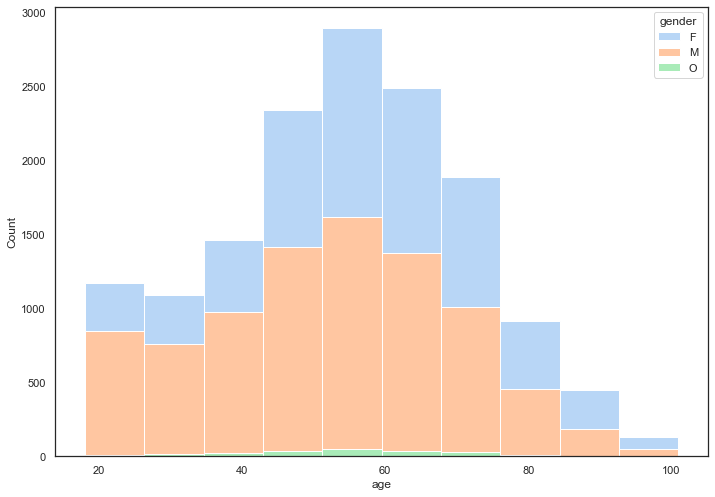

In [49]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(profile, x="age", hue="gender", bins = 10, multiple="stack");

It looks like age of customers follow normal distribution with slight skew towards younger demographic

`2.` **What is the income distribution of Starbucks customers?**

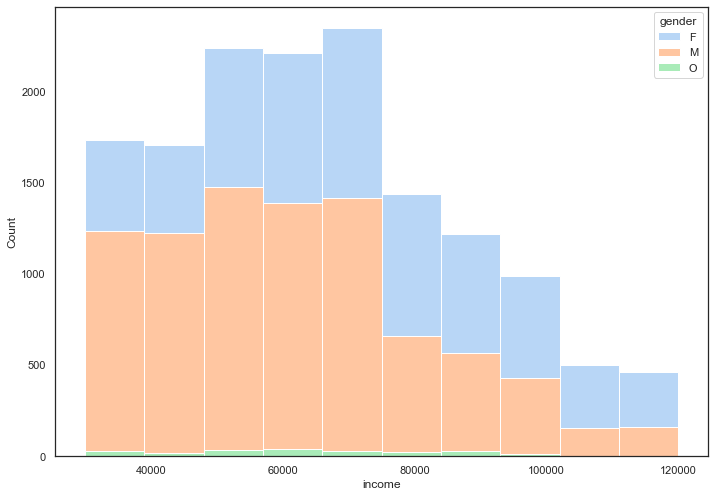

In [50]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.histplot(profile, x="income", hue="gender", bins = 10, multiple="stack");

Most of Starbucks customers earn 80k or less. Larger proportion of less earning customers are male, and females are a larger proportion of a higher income customers.

`3.` **How many people joined Starbucks membership each year?**

It looks like membership became more popular after 2017, but every year Starbucks saw more and more people joining the app. Most of people joined in 2017, possibly following some kind of promotion.

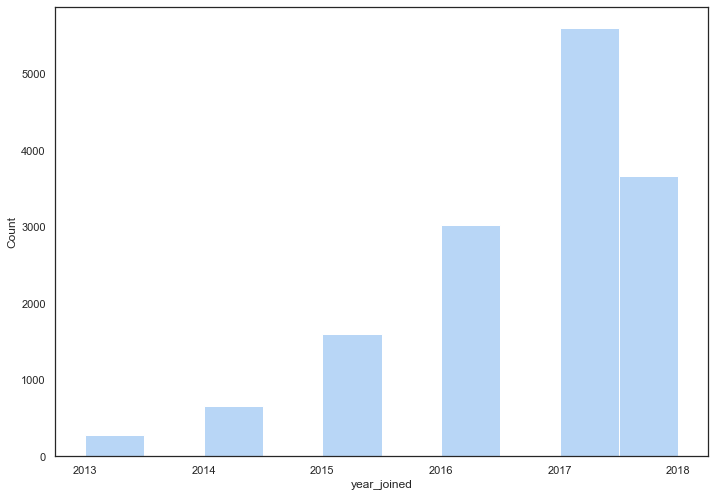

In [51]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.histplot(profile, x="year_joined", bins = 10, multiple="stack");

`4.` **How many people abandoned each kind of offers? Which offers get abandoned the most? Least?**

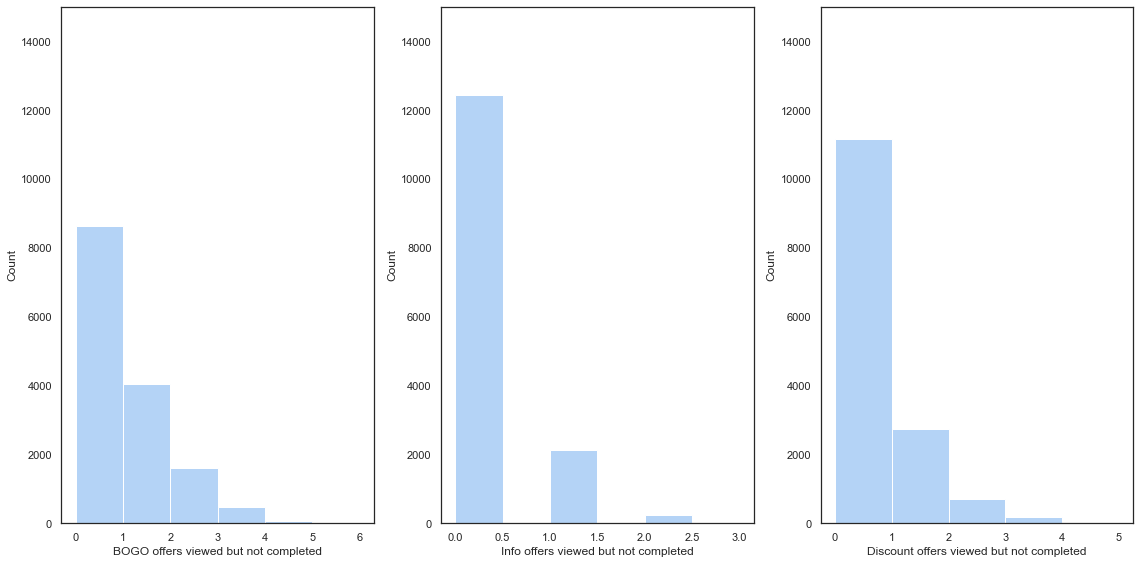

In [52]:
f, axs = plt.subplots(1, 3, figsize=(16, 8))
sns.histplot(data=profile, x="offer_bogo_not_completed", alpha=.8, legend=False,
             binwidth = 1, ax=axs[0])
sns.histplot(data=profile, x="offer_informational_not_completed", alpha=.8, legend=False,
             binwidth = 0.5, ax=axs[1])
sns.histplot(data=profile, x="offer_discount_not_completed", alpha=.8, legend=False,
             binwidth = 1, ax=axs[2])

axs[0].set(xlabel='BOGO offers viewed but not completed', ylabel='Count')
axs[0].set(ylim=(0, 15000))
axs[1].set(xlabel='Info offers viewed but not completed', ylabel='Count')
axs[1].set(ylim=(0, 15000))
axs[2].set(xlabel='Discount offers viewed but not completed', ylabel='Count')
axs[2].set(ylim=(0, 15000))


f.tight_layout()

There are a lot of offers that users viewed but not completed. The graphics above captures each time every customer did not follow through with the offer after viewing it. It appears that the most successful offer type is "Buy One get One" since it has the least number of customers that did not pursue it after viewing. The most informational offers were not followed through.

`5.` **What rate of completion for each offer? How do they compare within each type?**

In [53]:
bogo_ids = portfolio[portfolio['offer_type'] == 'bogo']['offer_id'].to_list()
discount_ids = portfolio[portfolio['offer_type'] == 'discount']['offer_id'].to_list()
info_ids = portfolio[portfolio['offer_type'] == 'informational']['offer_id'].to_list()

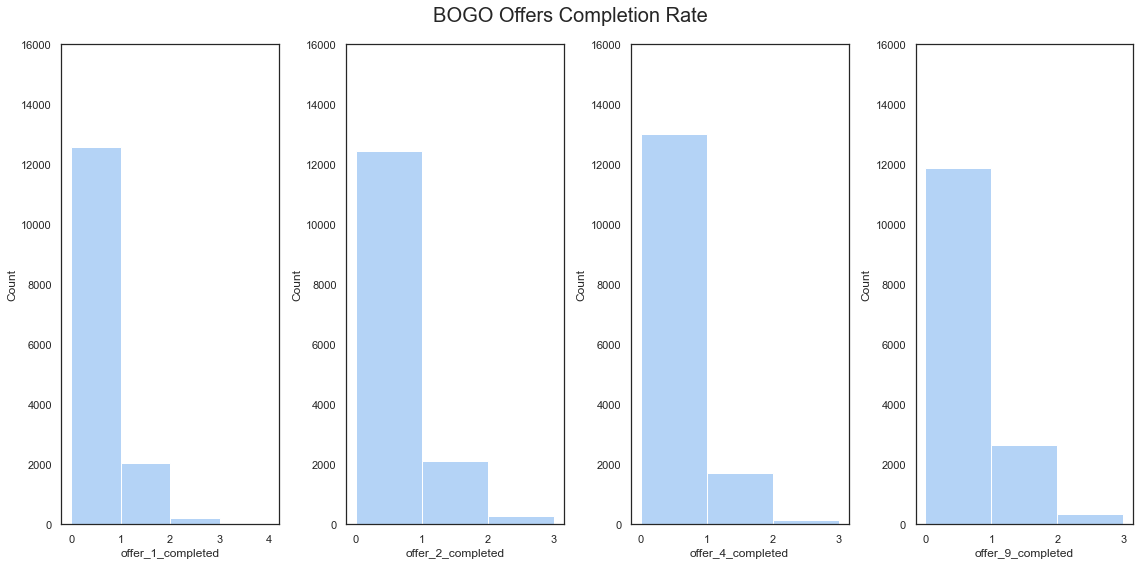

In [54]:
f, axs = plt.subplots(1, len(bogo_ids), figsize=(16, 8))
for idx in range(len(bogo_ids)):
    sns.histplot(data=profile, x="offer_{}_completed".format(bogo_ids[idx]),
                 alpha=.8, legend=False,
                 binwidth = 1, ax = axs[idx])
    axs[idx].set(ylim=(0, 16000))
    
f.suptitle('BOGO Offers Completion Rate', fontsize=20)
f.tight_layout()

BOGO offers are completed and abandoned with a very similar rate. The difference between these offers are difficulty and validity period, which seem to not have any affect on the rate of completion.

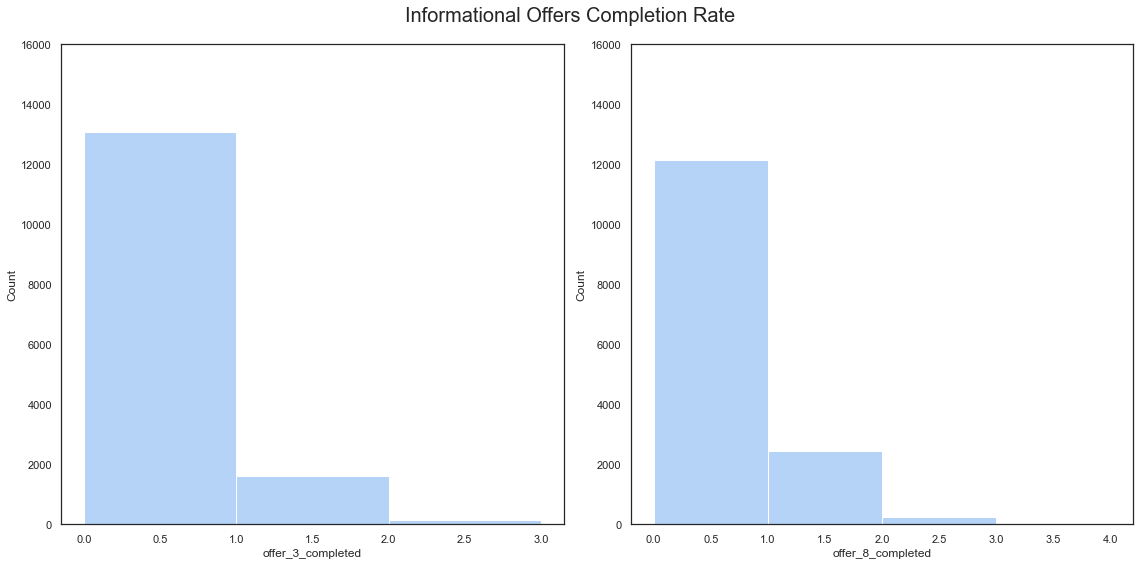

In [55]:
f, axs = plt.subplots(1, len(info_ids), figsize=(16, 8))
for idx in range(len(info_ids)):
    sns.histplot(data=profile, x="offer_{}_completed".format(info_ids[idx]),
                 alpha=.8, legend=False,
                 binwidth = 1, ax = axs[idx])
    
    axs[idx].set(ylim=(0, 16000))
    
f.suptitle('Informational Offers Completion Rate', fontsize=20)
f.tight_layout()

Same goes for informational offers. People get just as affected by longer running ads as shorter ones.

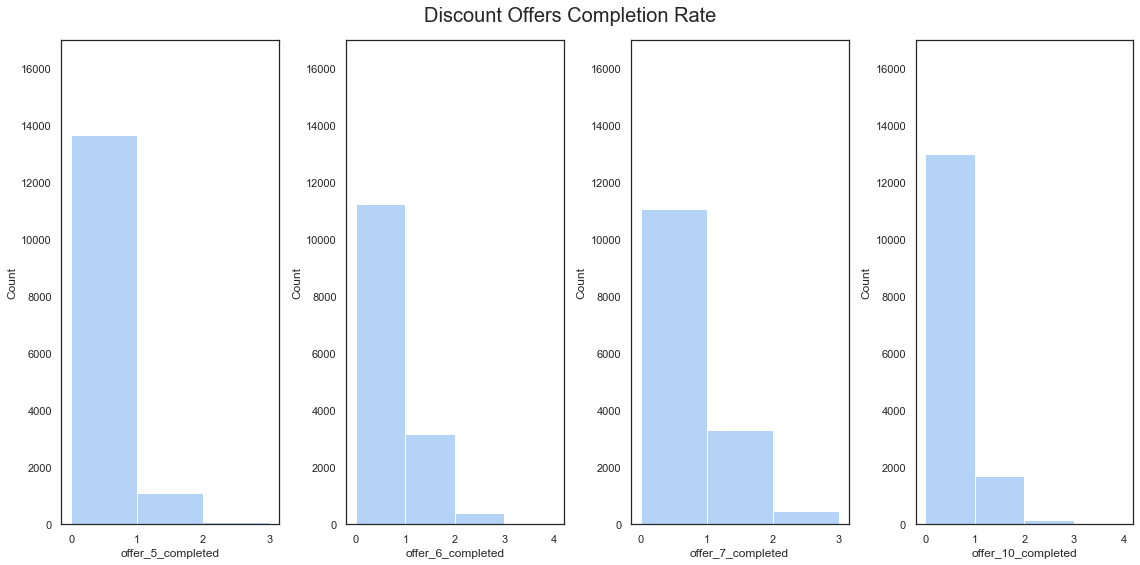

In [56]:
f, axs = plt.subplots(1, len(discount_ids), figsize=(16, 8))
for idx in range(len(discount_ids)):
    sns.histplot(data=profile, x="offer_{}_completed".format(discount_ids[idx]),
                 alpha=.8, legend=False,
                 binwidth = 1, ax = axs[idx])
    
    axs[idx].set(ylim=(0, 17000))
    
f.suptitle('Discount Offers Completion Rate', fontsize=20)
f.tight_layout()

In [57]:
portfolio[portfolio['offer_type']=='discount']

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,discount,informational,duration_hours
4,5,20,10,discount,5,1,0,0,1,1,0,240
5,3,7,7,discount,6,1,1,1,1,1,0,168
6,2,10,10,discount,7,1,1,1,1,1,0,240
9,2,10,7,discount,10,1,1,0,1,1,0,168


Discount offers show a little more variety in their completion rates. Offers 5 and 10 were abandoned the most as offer 5 requires the most amount spent, while offer 10 is giving the least discount value.

`6.` **What is the general demographic of people who ignore offers, not viewing them?**

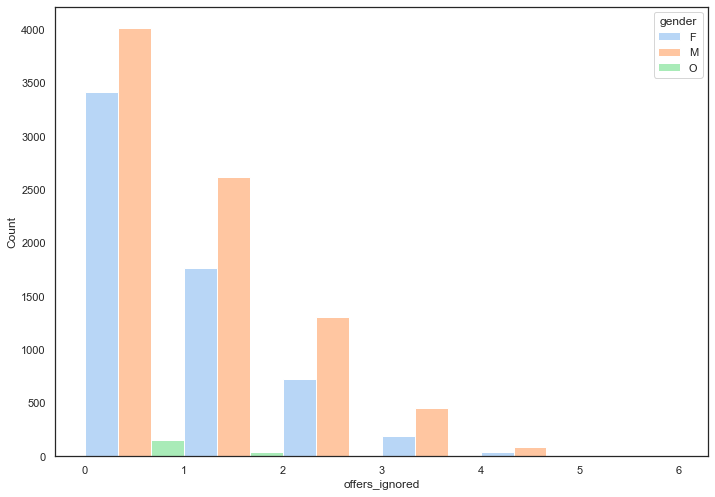

In [58]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.histplot(profile, x="offers_ignored", hue="gender", multiple = 'dodge',
            binwidth = 1);

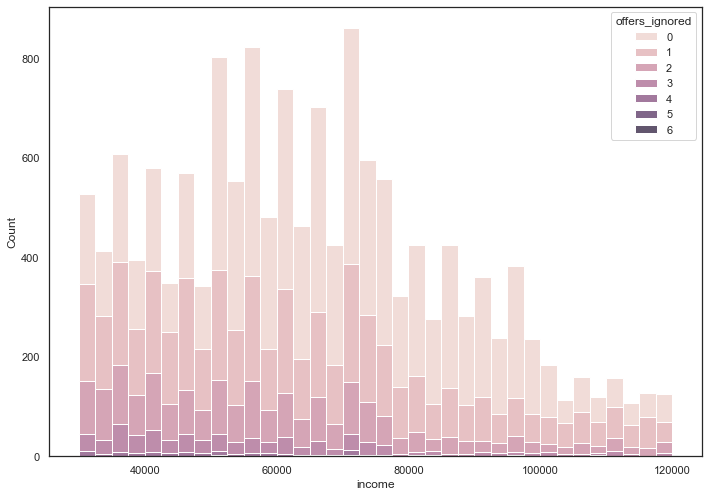

In [59]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.histplot(profile, x="income", hue="offers_ignored", multiple = 'stack');

According to the graphics above, it looks like male consistently ignored more offers than female.  Even though male seem to ignore offers more consistently, they also ignored zero offers more frequently. It means these offers were completed or at least viewed.

There are more people on the lower income spectrum who did not ignore any offers. There are also more people on the lower than 80k income in the entire Starbucks demographic. However, looking at the proportion to a total income bracket, there are more offer enthusiasts on the lower income bracket.

`7.` **What is the general demographic of people who complete offers by accident?**

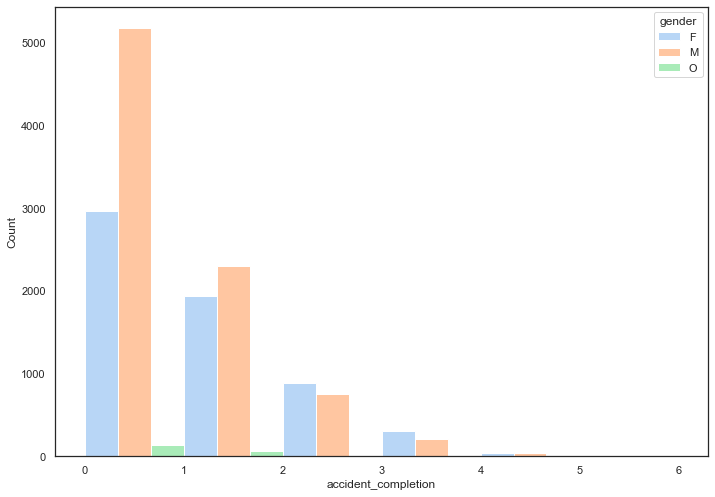

In [60]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.histplot(profile, x="accident_completion", hue="gender", multiple = 'dodge',
            binwidth = 1);

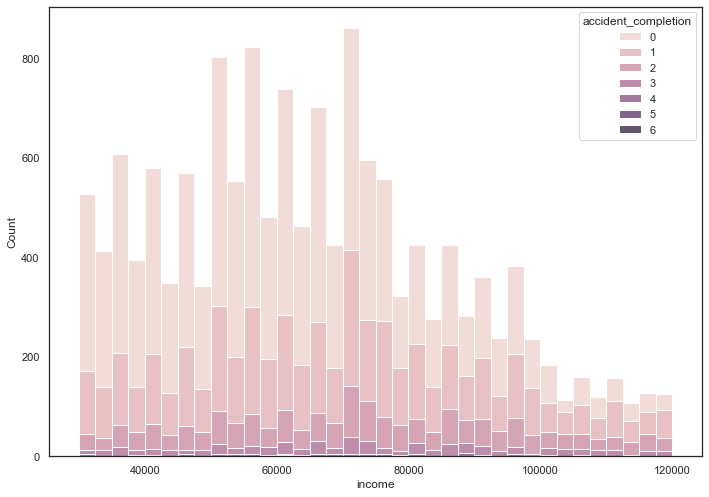

In [61]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.histplot(profile, x="income", hue="accident_completion", multiple = 'stack');

For Accident completion as well as for Offers Ignored metric, it is very tricky to make sense of the zero value. Male and female customers completed offers accidentally at almost the same rate, but males but far did not complete accidentally more offers.

As in the previous question, we discovered that there are more offer enthusiasts in the lower income bracket, people who earn less than 80k tend to miss less offers. These people also tend to not complete offers accidentally, which means they are probably tend to check the app for offers more often. There is a larger proportion of people who completed offers accidentally among higher earners.

`8.` **What is the distribution of total rewards and amount spent by customers?**

(0.0, 40.0)

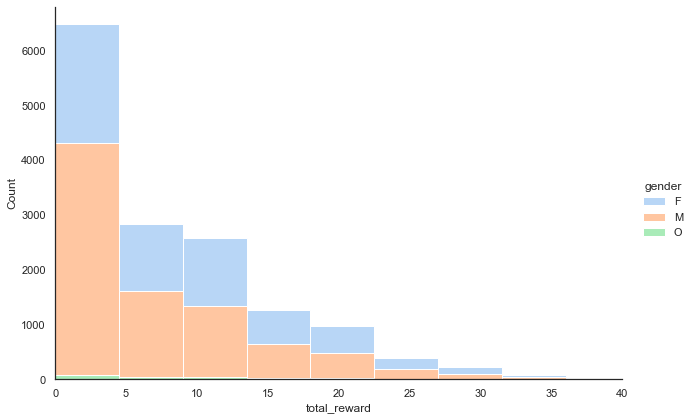

In [62]:
sns.displot(x = 'total_reward', hue = 'gender', data = profile,
            height=6, aspect=1.5, multiple = 'stack', bins = 10);
plt.xlim(0, 40)

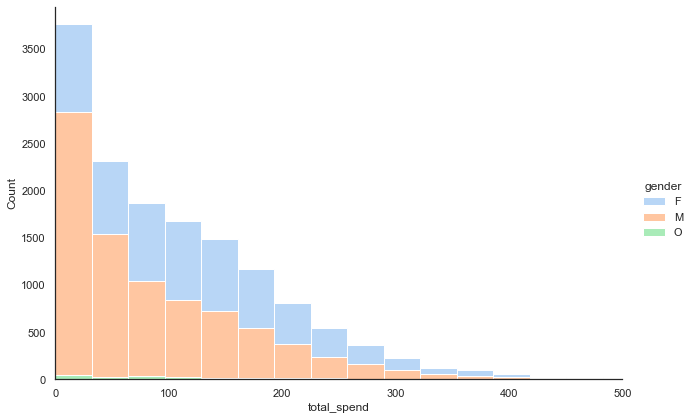

In [63]:
sns.displot(x = 'total_spend', hue = 'gender', data = profile,
            height=6, aspect=1.5, multiple = 'stack', bins = 50);
plt.xlim(0, 500);

Most of people did not spend much in Starbucks during the experiment, distribution of spending is heavily skewed to the left. Consequently, total reward amount is also skewed to the left, since the least people spend in offers, the less rewards they receive. Same as in income distribution, male make up a very large proportion of spend and rewards amounts.

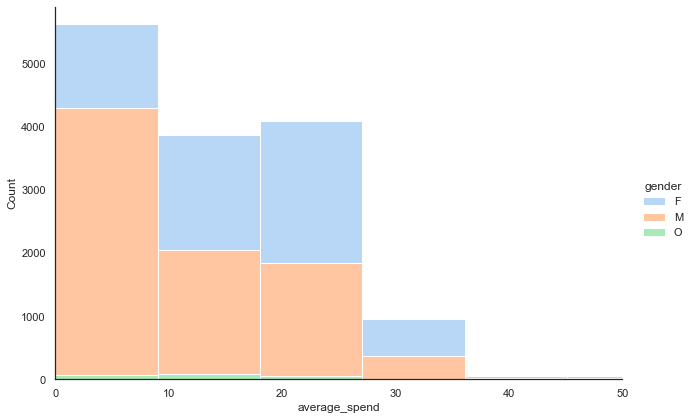

In [64]:
sns.displot(x = 'average_spend', hue = 'gender', data = profile,
            height=6, aspect=1.5, multiple = 'stack', bins = 50);
plt.xlim(0, 50);

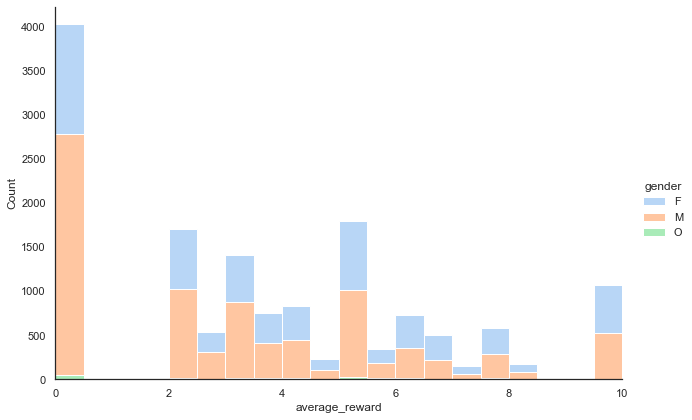

In [65]:
sns.displot(x = 'average_reward', hue = 'gender', data = profile,
            height=6, aspect=1.5, multiple = 'stack', bins = 20);
plt.xlim(0, 10);

Looking at the average reward chart, it appears that people are either not passionate about offers, or offer enthusiasts, or something in the middle

`9.` and `10.` **What is the most and least popular offer?**

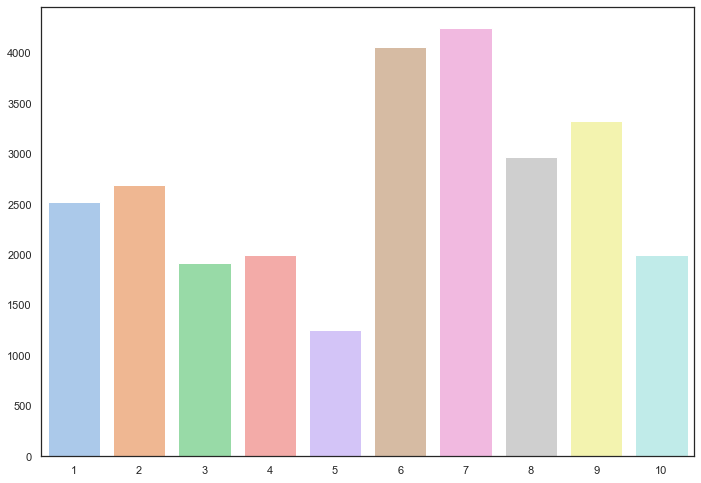

In [66]:
offers_comp = pd.DataFrame(np.sum(profile[target_colnames])).T
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.barplot(data = offers_comp, ax = ax);
ax.set_xticklabels(range(1, 11));

According to the chart above, the most popular offer is the offer 7 and the offer 5 is the least popular.

In [67]:
portfolio[(portfolio['offer_id']==5) | (portfolio['offer_id']==7)][['reward', 'difficulty',
                                                                    'duration', 'offer_type',
                                                                   'discount', 'offer_id']]

,reward,difficulty,duration,offer_type,discount,offer_id
4,5,20,10,discount,1,5
6,2,10,10,discount,1,7


Both of these offers are discount offers with duration of 10 days. Surprisingly, the difficulty of 20 prevents people from completing the offer 5, while difficulty 10 with reward 2 wakes offer 7 the most popular.

## Machine Learning Algorithm

In [68]:
def train_predict_result(model, X_train, y_train, X_test, y_test):
    results = {}
    
    #fit the model
    model.fit(X_train, y_train)
    
    #predict test
    y_pred_test = model.predict(X_test)
    
    #predict train
    y_pred_train = model.predict(X_train)
    
    #Accuracy of training
    results['acc_train'] = accuracy_score(y_train, y_pred_train)
    
    #Accuracy of testing
    results['acc_test'] = accuracy_score(y_test, y_pred_test)
    
    #f1-score for training
    results['f1_train'] = f1_score(y_train, y_pred_train)
    
    #f1-score for testing
    results['f1_test'] = f1_score(y_test, y_pred_test)
    
    print("{} trained.".format(model.__class__.__name__))
        
    # Return the results
    return results

In [69]:
# get dummies for gender column
df_cat = pd.get_dummies(profile_exploded['gender'], dummy_na = False, drop_first=True)
profile_exploded = profile_exploded.merge(df_cat, how = 'inner', left_index = True, right_index= True)

In [70]:
profile_exploded['years_member'] = datetime.datetime.today().year - profile_exploded['year_joined']
profile_exploded

,gender,age,customer_id,became_member_on,income,year_joined,offer_1_completed,offer_2_completed,offer_3_completed,offer_4_completed,...,email,mobile,social,web,discount,informational,duration_hours,M,O,years_member
0,F,55.0,1,2017-07-15,112000.0,2017,0,0,0,0,...,1,1,0,1,0,1,96,0,0,4
1,F,55.0,1,2017-07-15,112000.0,2017,0,0,0,0,...,1,1,0,1,0,0,168,0,0,4
2,F,75.0,2,2017-05-09,100000.0,2017,1,0,0,1,...,1,1,1,0,0,0,168,0,0,4
3,F,75.0,2,2017-05-09,100000.0,2017,1,0,0,1,...,1,1,0,1,0,0,168,0,0,4
4,F,75.0,2,2017-05-09,100000.0,2017,1,0,0,1,...,1,1,1,0,0,1,72,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,F,83.0,14824,2016-03-07,50000.0,2016,0,1,0,0,...,1,1,1,1,0,0,120,0,0,5
55218,F,83.0,14824,2016-03-07,50000.0,2016,0,1,0,0,...,1,1,0,1,0,0,168,0,0,5
55219,F,62.0,14825,2017-07-22,82000.0,2017,0,0,0,0,...,1,1,0,1,0,1,96,0,0,4
55220,F,62.0,14825,2017-07-22,82000.0,2017,0,0,0,0,...,1,1,1,1,1,0,168,0,0,4


In [71]:
X = profile_exploded.drop(target_colnames, axis = 1)
X = X.drop(['gender', 'customer_id', 'became_member_on', 'year_joined', 'offer_dict', 'offer_id', 'offer_type', 'offer_completed'], axis = 1)


Y = profile_exploded['offer_completed']

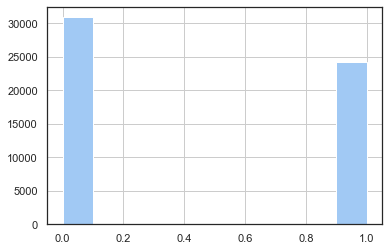

In [72]:
Y.hist();

In [73]:
# Train set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1/3, random_state=0)

Optionally, we could also scale the data, as it could potentially improve model performance. At this point, we are going to proceed without re-scaling the data.

In [74]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [75]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [116]:
from sklearn.naive_bayes import GaussianNB 
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

In [77]:
# Initialize the models

logreg = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=600,
                            random_state=10)
randomforestclf = RandomForestClassifier(random_state=10)
gnb = GaussianNB()
knn = KNeighborsClassifier() 
dectree = DecisionTreeClassifier()
xgb = XGBClassifier(use_label_encoder=False,
                   objective = 'binary:logistic',
                   eval_metric = 'error')

models = [logreg, randomforestclf, gnb, knn, dectree, xgb]

In [78]:
result_dict = {}
for model in models:
    model_name = model.__class__.__name__
    result_dict[model_name] = train_predict_result(model, X_train, y_train, X_test, y_test)

LogisticRegression trained.
RandomForestClassifier trained.
GaussianNB trained.
KNeighborsClassifier trained.
DecisionTreeClassifier trained.
XGBClassifier trained.


In [79]:
for mod in range(len(models)):
    print(models[mod].__class__.__name__, ":")
    display(pd.DataFrame(result_dict[models[mod].__class__.__name__], index = range(1)))
    print('===================================\n\n')

LogisticRegression :


,acc_train,acc_test,f1_train,f1_test
0,0.719156,0.71382,0.687086,0.67878




RandomForestClassifier :


,acc_train,acc_test,f1_train,f1_test
0,1.0,0.872392,1.0,0.854758




GaussianNB :


,acc_train,acc_test,f1_train,f1_test
0,0.72994,0.728651,0.707674,0.70428




KNeighborsClassifier :


,acc_train,acc_test,f1_train,f1_test
0,0.784538,0.666341,0.757372,0.621612




DecisionTreeClassifier :


,acc_train,acc_test,f1_train,f1_test
0,1.0,0.823066,1.0,0.796374




XGBClassifier :


,acc_train,acc_test,f1_train,f1_test
0,0.921769,0.873533,0.913232,0.858222


- **Logistic Regression** performed the weakest in both training and testing, with accuracy 71.9% in training and 71.3% on testing.

- **RandomForestClassifier** and **DecisionTreeClassifier** are both examples of overfitting: 100% accuracy on training data and 82% - 87% for testing. Because both of these models overfit in training, we are not going to use them in further analysis. 

- The best result for the base models are:
    - **GaussianNB** with f1 score of 0.71 and accuracy 72.8%
    - **KNeighbors Classifier** with f1 score of 0.62 and accuracy 66.6%
    - **XGBClassifier** with f1 score 0.86 and accuracy 87.4%
    
All of these models show realistically good performance, we really do not want anything near 100% accuracy, as it could be an indication of training data leaking into testing set.

We are going to proceed with XGBClassifier for further analysis.

## Grid Search to improve the best performing base model

In [80]:
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'error'}

In [103]:
# create a dictionary of parameters to test
xgb_grid_params = {'objective': ['binary:logistic'],
                   'eval_metric': ['error'],
                   'use_label_encoder':[False],
                 'gamma': [0, 0.5],
                 'learning_rate': [0.300000012, 0.25, 0.35],
                 'max_depth': [6, 5, 7]}

In [104]:
# configure the cross-validation procedure
cv = KFold(n_splits=6, shuffle=True, random_state=1)

xgb_grid = GridSearchCV(estimator=xgb,
                    param_grid=xgb_grid_params,
                    scoring='accuracy',
                    cv = cv,
                    verbose=10)
xgb_grid.fit(X_train, y_train)

Fitting 6 folds for each of 18 candidates, totalling 108 fits
[CV 1/6; 1/18] START eval_metric=error, gamma=0, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False
[CV 1/6; 1/18] END eval_metric=error, gamma=0, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False; total time=   0.9s
[CV 2/6; 1/18] START eval_metric=error, gamma=0, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False
[CV 2/6; 1/18] END eval_metric=error, gamma=0, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False; total time=   0.9s
[CV 3/6; 1/18] START eval_metric=error, gamma=0, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False
[CV 3/6; 1/18] END eval_metric=error, gamma=0, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False; total time=   0.8s
[CV 4/6; 1/18] START eval_metric=error, gamm

[CV 5/6; 5/18] END eval_metric=error, gamma=0, learning_rate=0.25, max_depth=5, objective=binary:logistic, use_label_encoder=False; total time=   0.9s
[CV 6/6; 5/18] START eval_metric=error, gamma=0, learning_rate=0.25, max_depth=5, objective=binary:logistic, use_label_encoder=False
[CV 6/6; 5/18] END eval_metric=error, gamma=0, learning_rate=0.25, max_depth=5, objective=binary:logistic, use_label_encoder=False; total time=   0.8s
[CV 1/6; 6/18] START eval_metric=error, gamma=0, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=False
[CV 1/6; 6/18] END eval_metric=error, gamma=0, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=False; total time=   1.2s
[CV 2/6; 6/18] START eval_metric=error, gamma=0, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=False
[CV 2/6; 6/18] END eval_metric=error, gamma=0, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=False; total time=   1.

[CV 4/6; 10/18] END eval_metric=error, gamma=0.5, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False; total time=   0.9s
[CV 5/6; 10/18] START eval_metric=error, gamma=0.5, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False
[CV 5/6; 10/18] END eval_metric=error, gamma=0.5, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False; total time=   0.9s
[CV 6/6; 10/18] START eval_metric=error, gamma=0.5, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False
[CV 6/6; 10/18] END eval_metric=error, gamma=0.5, learning_rate=0.300000012, max_depth=6, objective=binary:logistic, use_label_encoder=False; total time=   0.9s
[CV 1/6; 11/18] START eval_metric=error, gamma=0.5, learning_rate=0.300000012, max_depth=5, objective=binary:logistic, use_label_encoder=False
[CV 1/6; 11/18] END eval_metric=error, gamma=0.5, learning_rate=0.300000012, max_depth=5

[CV 2/6; 15/18] END eval_metric=error, gamma=0.5, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=False; total time=   1.2s
[CV 3/6; 15/18] START eval_metric=error, gamma=0.5, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=False
[CV 3/6; 15/18] END eval_metric=error, gamma=0.5, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=False; total time=   1.3s
[CV 4/6; 15/18] START eval_metric=error, gamma=0.5, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=False
[CV 4/6; 15/18] END eval_metric=error, gamma=0.5, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=False; total time=   1.3s
[CV 5/6; 15/18] START eval_metric=error, gamma=0.5, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=False
[CV 5/6; 15/18] END eval_metric=error, gamma=0.5, learning_rate=0.25, max_depth=7, objective=binary:logistic, use_label_encoder=Fa

GridSearchCV(cv=KFold(n_splits=6, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='error',
                                     gamma=0, gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,...
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact',
                                     use_label_encoder=False,
                             

## Model Evaliation and Validation

In [ ]:
#show the best parameters based on grid search
best_params = xgb_grid.best_params_
best_params

In [106]:
xgb_acc = {}
# instantiate and train model with best parameters
xgb_best = XGBClassifier(eval_metric= 'error',
                         gamma=0.5,
                        learning_rate = 0.25,
                        max_depth = 5,
                        objective = 'binary:logistic',
                        use_label_encoder = False)
xgb_acc['XGBoost Classifier'] = train_predict_result(xgb_best,X_train, y_train, X_test, y_test)

XGBClassifier trained.


In [107]:
print(xgb_best.__class__.__name__, ":")
display(pd.DataFrame(xgb_acc['XGBoost Classifier'], index = range(1)))

XGBClassifier :


,acc_train,acc_test,f1_train,f1_test
0,0.89762,0.876304,0.886766,0.862309


[Source of the following function](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)

In [139]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(10, 30))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

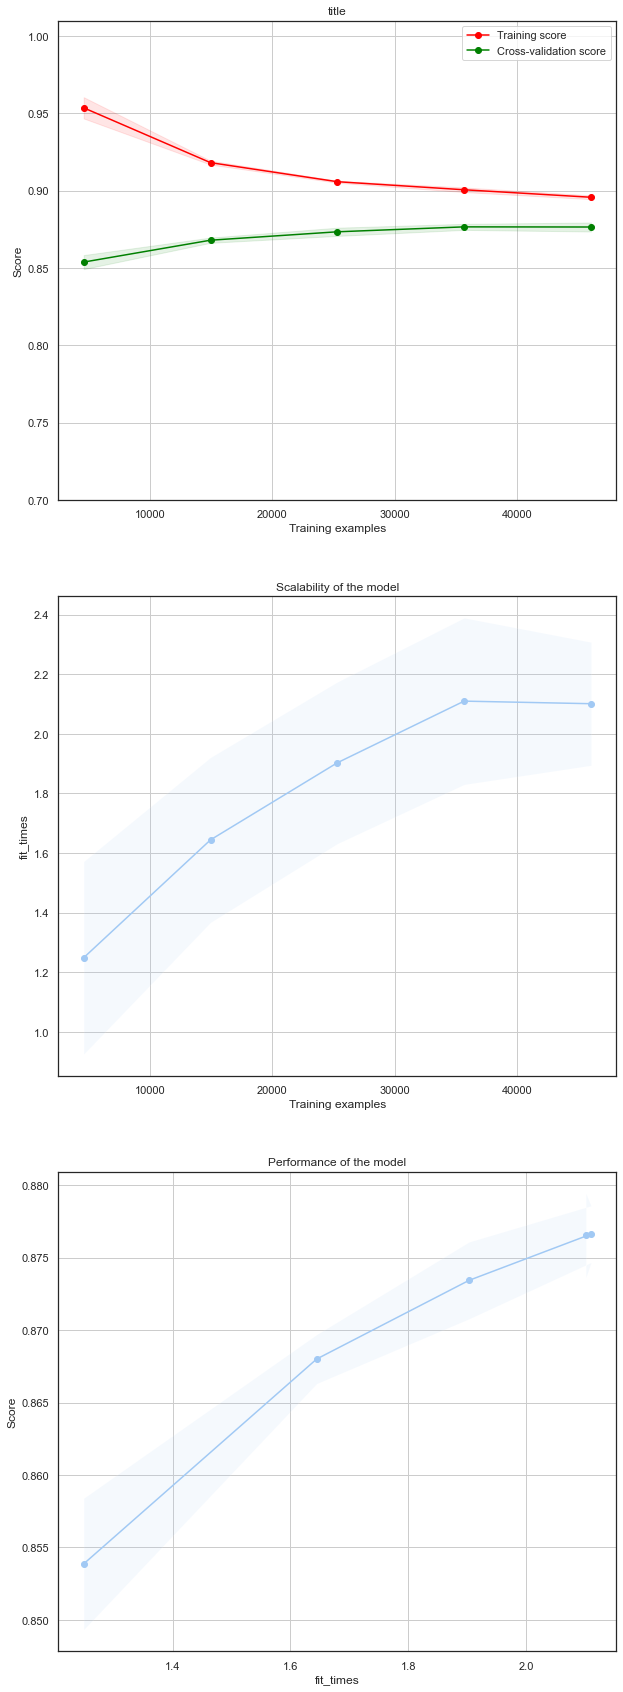

In [142]:
plot_learning_curve(xgb_best, 'title', X, Y, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4);

Using GridSearch with kFold cross-validation algorithm, we have fitted XGBoost Classifier 108 times to come up with the parameters that create the most accurate model. The charts above illustrate the performance of the model with the best parameters with each Fold cross validation. Training set starts of with a very high accuracy that is decreasing with each fold, while performance of cross-validation increases. However, performance of the model does not fluctuate with each fold and is more or less stable. The plots in the second row show the times required by the models to train with various sizes of training dataset. The last chart shows that the performance score of the model increased with each fit.

### Model Output, Metrics, Evaluation of customers, and Justification

Evaluate the model for some customers

In [108]:
y_pred = xgb_best.predict(X_test)

In [109]:
cust1 = 48352
print('Customer Info:')
display(pd.DataFrame(X_test.loc[cust1]))
print("The actual offer status: {}\nThe model predicted value: {}"
      .format(y_test.loc[cust1], xgb_best.predict(pd.DataFrame(X_test.loc[cust1]).T)[0]))

Customer Info:


,48352
age,79.000
income,91000.000
total_spend,79.380
average_spend,19.845
total_reward,12.000
average_reward,6.000
accident_completion,2.000
offers_ignored,0.000
offer_bogo_not_completed,0.000
offer_informational_not_completed,0.000


The actual offer status: 1
The model predicted value: 1


The model predicted that the customer with the demographic described above is going to complete the BOGO offer, and the test data confirms that the customer indeed completed the offer. 

In [110]:
cust1 = 2982
print('Customer Info:')
display(pd.DataFrame(X_test.iloc[cust1]))
print("The actual offer status: {}\nThe model predicted value: {}"
      .format(y_test.iloc[cust1], xgb_best.predict(pd.DataFrame(X_test.iloc[cust1]).T)[0]))

Customer Info:


,52366
age,64.000000
income,56000.000000
total_spend,45.600000
average_spend,4.145455
total_reward,3.000000
average_reward,3.000000
accident_completion,1.000000
offers_ignored,1.000000
offer_bogo_not_completed,2.000000
offer_informational_not_completed,0.000000


The actual offer status: 0
The model predicted value: 0


Both testing data and the model predicted that this customer described above is not going to complete the informational offer.

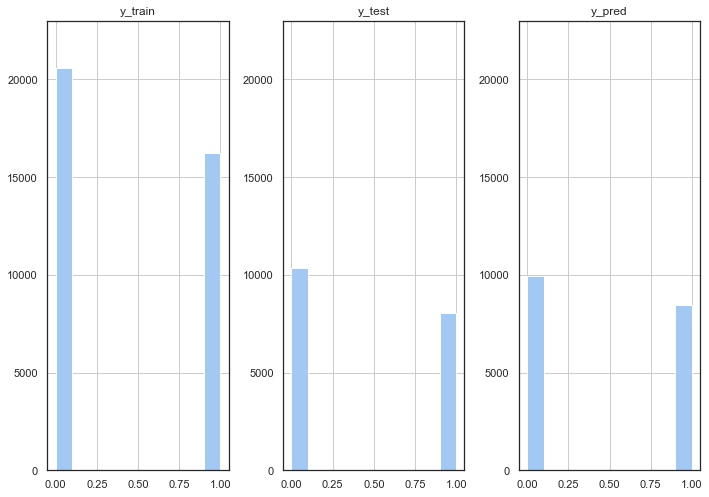

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(11.7, 8.27))
y_train.hist(ax = ax[0]);
y_test.hist(ax = ax[1]);
pd.DataFrame(y_pred).hist(ax = ax[2])
ax[0].set_title('y_train');
ax[1].set_title('y_test');
ax[2].set_title('y_pred');
for idx in [0,1,2]:
    ax[idx].set(ylim=(0, 23000))

In [112]:
print("The number of time the model predicting that the customer completes the offer correctly is: ", y_test[(y_test==y_pred)&(y_test == 1)].shape[0])
print("The number of time the model predicting that the customer does not complete the offer correctly is: ", y_test[(y_test==y_pred)&(y_test == 0)].shape[0])
print("Total number of labels to predict: ", y_test.shape[0])
print("The portion of total labels the customer completes the offer predicted correctly ",round(y_test[(y_test==y_pred)&(y_test == 1)].shape[0]/y_test[(y_test == 1)].shape[0],2))

The number of time the model predicting that the customer completes the offer correctly is:  7130
The number of time the model predicting that the customer does not complete the offer correctly is:  9001
Total number of labels to predict:  18408
The portion of total labels the customer completes the offer predicted correctly  0.89


In [113]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89     10352
           1       0.84      0.89      0.86      8056

    accuracy                           0.88     18408
   macro avg       0.87      0.88      0.88     18408
weighted avg       0.88      0.88      0.88     18408



In [115]:
display_results(y_pred, y_test)

Labels: [0 1]
Confusion Matrix:
 [[9001 1351]
 [ 926 7130]]
Accuracy: 0.8763037809647979


It looks like the model is predicting about 88% of positive labels correctly, which is pretty good. It means that the model actually suggests us to send the offers to customers and people are making purchases and following through consciously (not accidentally) in 88% of the time.

The final model has **87.63% accuracy and 0.88 recall**. Considering that the accuracy of training and testing set are both around 87%-90% is promising that the model is not prone to overfitting and would perform with consistent accuracy on unseen data.

Using the model generated during this study, the business would be able to input each customer's demographic data and transaction/offer interaction history and potential offer details. The model would predict whether or not the offer should be sent to a particular customer with 87% accuracy.

## Improvement
The next steps in improving model performance could be running a longer experiment with more customers, collecting more demographic data on customers, such as Starbucks location of purchase, drink review scores, day and times of transactions (time in our dataset represented time elapsed since beginning of the experiment) etc. 
It is important to create a A/B testing experiment between similar users: send random offers to some, while others would get to use the model.